# Kernel Tuning

In [31]:
!pip install pandas
!pip install sklearn

import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
from sklearn.svm import SVR

# empty list to append metric values
mae_gen = []
mae_nor = []
mae_spi = []
rmse_gen = []
rmse_nor = []
rmse_spi = []

# Data set processing and tuning:

In [32]:
data = pd.read_csv('Data_set_1_smaller.csv', index_col = 0)

# set predictive window 
data = data.loc[data.index > 2018070000, :]

# reset index
data.reset_index(inplace = True)
data.drop('index', axis = 1, inplace = True)

# divide features and labels
X = data.iloc[:, 0:15]
y = data.loc[:, 'Offers']

X.fillna(X.median(), inplace = True)
y.fillna(y.median(), inplace = True)

# small fix
X = X.astype('float64')
X = X.round(20)

# divide into train and test
X_train, X_test, y_train, y_test = train_test_split(
         X, y, test_size = 0.075, shuffle = False)

# feature scaling
sc_X = MinMaxScaler()
X_train = sc_X.fit_transform(X_train)
X_test = sc_X.transform(X_test)

# the different regressors to train
# gamma = kernel coefficient for ‘rbf’, ‘poly’ and ‘sigmoid’
svr_rbf_auto = SVR(kernel='rbf', gamma= 'auto')
svr_rbf_scale = SVR(kernel='rbf', gamma= 'scale')
svr_poly_auto = SVR(kernel='poly', gamma='auto')
svr_poly_scale = SVR(kernel='poly', gamma='scale')
svr_sigmoid_auto = SVR(kernel='sigmoid', gamma='auto')
svr_sigmoid_scale = SVR(kernel='sigmoid', gamma='scale')
svr_lin = SVR(kernel='linear')

kernel_range = [svr_rbf_auto, svr_rbf_scale, 
                svr_poly_auto, svr_poly_scale,
                svr_sigmoid_auto, svr_sigmoid_scale,
                svr_lin ]

kernel_label = ['RBF auto', 'RBF scale',
                'Polynomial auto', 'Polynomial scale',
                'Sigmoid auto', 'Sigmoid scale',
                'Linear']

# loop
for i in kernel_range:
    # create regressor 
    regressor = i
    regressor.fit(X_train, y_train)

    # predict for X_test  
    y_pred = regressor.predict(X_test)

    from sklearn.metrics import mean_squared_error as mse
    from sklearn.metrics import mean_absolute_error as mae

    rmse_error = mse(y_test, y_pred, squared = False)
    mae_error = mae(y_test, y_pred) 
    
    rmse_gen.append(rmse_error)
    mae_gen.append(mae_error)
    
    # =============================================================================
    # Metrics evaluation on spike regions
    # =============================================================================
    
    y_spike_occ = pd.read_csv('Spike_binary_1std.csv', usecols = [6])
    
    # create array same size as y_test
    y_spike_occ = y_spike_occ.iloc[- len(y_test):]
    y_spike_occ = pd.Series(y_spike_occ.iloc[:,0]).values
    
    # smal adjustment
    y_test.replace(0, 0.0001,inplace = True)

    
    # select y_pred and y_test only for regions with spikes
    y_test_spike = (y_test.T * y_spike_occ).T
    y_pred_spike = (y_pred.T * y_spike_occ).T
    y_test_spike = y_test_spike[y_test_spike != 0]
    y_pred_spike = y_pred_spike[y_pred_spike != 0]
    
    # calculate metric
    rmse_spike = mse(y_test_spike, y_pred_spike, squared = False)
    mae_spike = mae(y_test_spike, y_pred_spike)
    
    rmse_spi.append(rmse_spike)
    mae_spi.append(mae_spike)
    
    # =============================================================================
    # Metric evaluation on normal regions
    # =============================================================================
    
    # inverse y_spike_occ so the only normal occurences are chosen
    y_normal_occ = (y_spike_occ - 1) * (-1)
    
    # sanity check
    y_normal_occ.sum() + y_spike_occ.sum() # gives the correct total 
    
    # select y_pred and y_test only for normal regions
    y_test_normal = (y_test.T * y_normal_occ).T
    y_pred_normal = (y_pred.T * y_normal_occ).T
    y_test_normal = y_test_normal[y_test_normal != 0.00]
    y_pred_normal = y_pred_normal[y_pred_normal != 0.00]
    
    # calculate metric
    rmse_normal = mse(y_test_normal, y_pred_normal, squared = False)
    mae_normal = mae(y_test_normal, y_pred_normal)
    
    rmse_nor.append(rmse_normal)
    mae_nor.append(mae_normal)

/home/ec2-user/anaconda3/envs/python-cpu/lib/python3.7/site-packages/pandas/core/generic.py:6245: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._update_inplace(new_data)


# Results:

In [33]:
results = pd.DataFrame({                        
                        'rmse_general': rmse_gen, 
                 
                        'mae_general': mae_gen,
                        
                        'rmse_spike': rmse_spi,
                 
                        'mae_spike': mae_spi,
                        
                        'rmse_normal': rmse_nor,
                    
                        'mae_normal': mae_nor}, index = kernel_range)

results

,rmse_general,mae_general,rmse_spike,mae_spike,rmse_normal,mae_normal
SVR(gamma='auto'),28.368926,14.233487,71.127639,57.589879,10.923932,7.247868
SVR(),28.055304,15.132729,69.362978,55.607667,11.778372,8.611372
"SVR(gamma='auto', kernel='poly')",28.646794,13.927801,71.885939,58.417876,10.966068,6.759523
SVR(kernel='poly'),28.170373,15.691576,68.938586,54.921079,12.477947,9.370886
"SVR(gamma='auto', kernel='sigmoid')",28.484339,14.094251,71.492764,57.940870,10.888567,7.029646
SVR(kernel='sigmoid'),29.138978,14.727637,72.756278,59.196848,11.532355,7.562720
SVR(kernel='linear'),28.175077,14.605476,70.309064,56.821384,11.191930,7.803613


# Highlight best results:

In [34]:
def highlight_min(s):
    '''
    highlight the maximum in a Series yellow.
    '''
    is_max = s == s.min()
    return ['background-color: yellow' if v else '' for v in is_max]

results.style.apply(highlight_min)

,rmse_general,mae_general,rmse_spike,mae_spike,rmse_normal,mae_normal
SVR(gamma='auto'),28.368926,14.233487,71.127639,57.589879,10.923932,7.247868
SVR(),28.055304,15.132729,69.362978,55.607667,11.778372,8.611372
"SVR(gamma='auto', kernel='poly')",28.646794,13.927801,71.885939,58.417876,10.966068,6.759523
SVR(kernel='poly'),28.170373,15.691576,68.938586,54.921079,12.477947,9.370886
"SVR(gamma='auto', kernel='sigmoid')",28.484339,14.094251,71.492764,57.940870,10.888567,7.029646
SVR(kernel='sigmoid'),29.138978,14.727637,72.756278,59.196848,11.532355,7.562720
SVR(kernel='linear'),28.175077,14.605476,70.309064,56.821384,11.191930,7.803613


In [35]:
!pip install matplotlib

# Plot results:

<IPython.core.display.Javascript object>


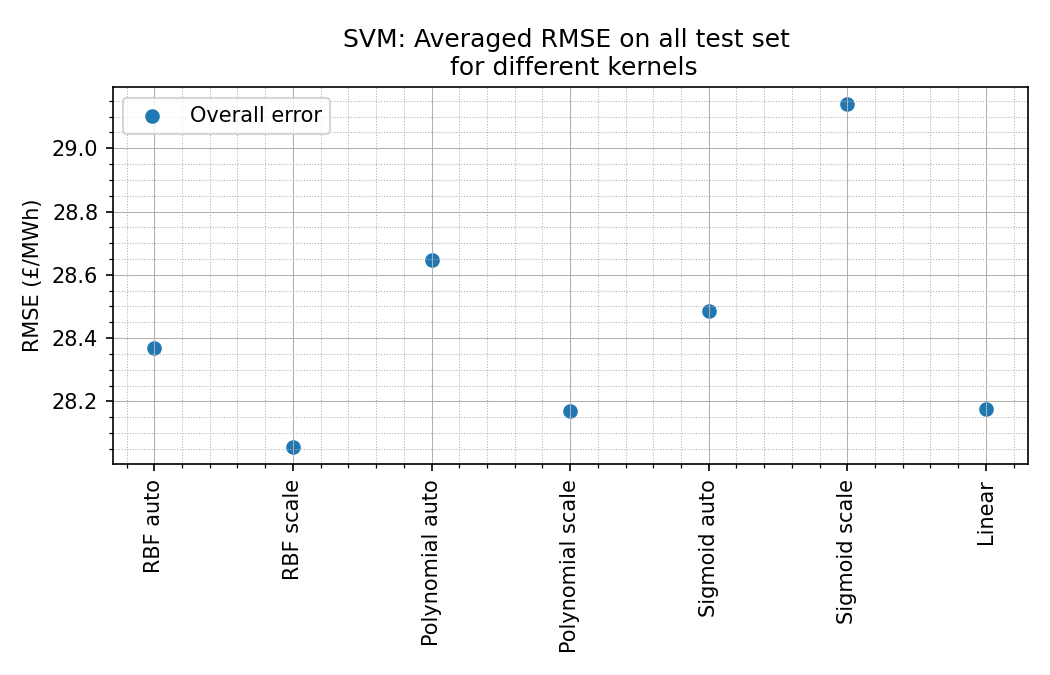

<IPython.core.display.Javascript object>


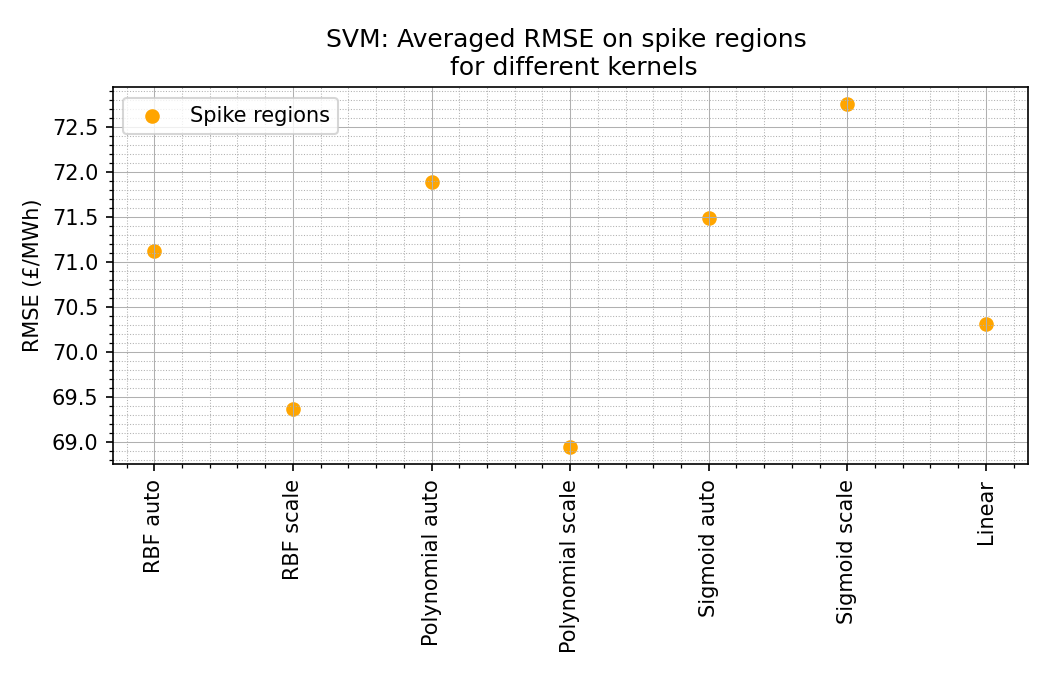

<IPython.core.display.Javascript object>


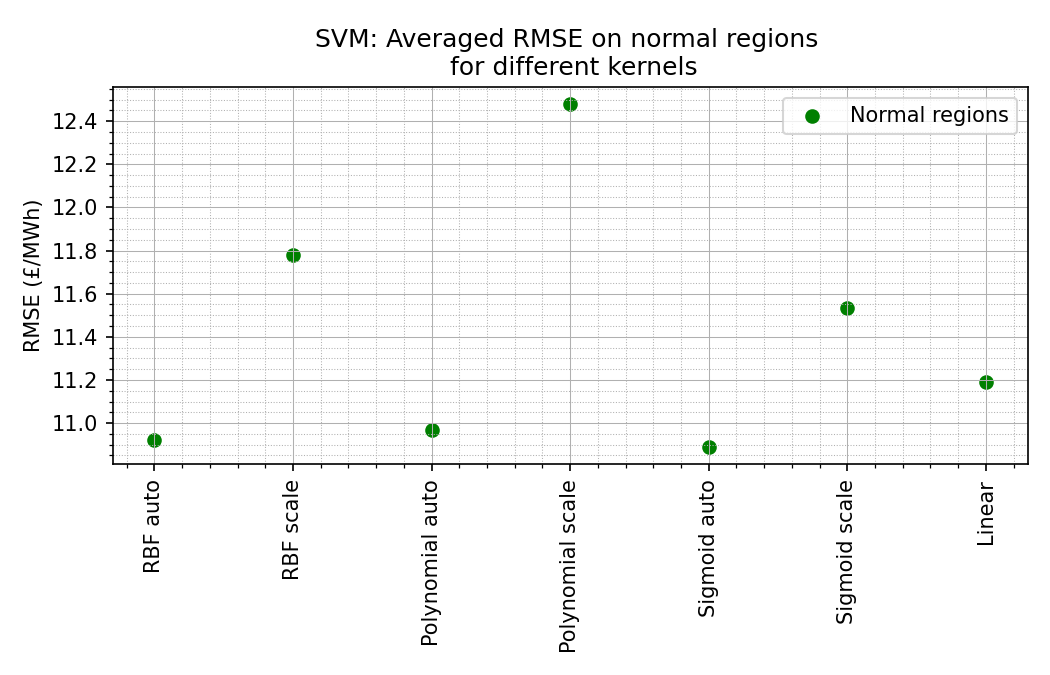

In [38]:
%matplotlib notebook

import matplotlib.pyplot as plt

plt.figure(figsize=(7,4.5))
plt.minorticks_on()
plt.grid(which='major', linestyle='-', linewidth='0.5')
plt.grid(which='minor', linestyle=':', linewidth='0.5')
plt.title('SVM: Averaged RMSE on all test set \n for different kernels')
plt.scatter(x = list(range(len(rmse_gen))), y = rmse_gen, label = 'Overall error')
plt.legend()
plt.ylabel('RMSE (£/MWh)')
plt.xticks(list(range(len(rmse_gen))), kernel_label, rotation = 90)
plt.tight_layout()
plt.savefig('RMSE_best_kernel_all.png')

plt.figure(figsize=(7,4.5))
plt.minorticks_on()
plt.grid(which='major', linestyle='-', linewidth='0.5')
plt.grid(which='minor', linestyle=':', linewidth='0.5')
plt.title('SVM: Averaged RMSE on spike regions \n for different kernels')
plt.scatter(x = list(range(len(rmse_gen))), y = rmse_spi, label = 'Spike regions', color = 'orange')
plt.legend()
plt.ylabel('RMSE (£/MWh)')
plt.xticks(list(range(len(rmse_gen))), kernel_label, rotation = 90)
plt.tight_layout()
plt.savefig('RMSE_best_kernel_spike.png')


plt.figure(figsize=(7,4.5))
plt.minorticks_on()
plt.grid(which='major', linestyle='-', linewidth='0.5')
plt.grid(which='minor', linestyle=':', linewidth='0.5')
plt.title('SVM: Averaged RMSE on normal regions \n for different kernels')
plt.scatter(x = list(range(len(rmse_gen))), y = rmse_nor, label = 'Normal regions', color = 'green')
plt.legend()
plt.ylabel('RMSE (£/MWh)')
plt.xticks(list(range(len(rmse_gen))), kernel_label, rotation = 90)
plt.tight_layout()
plt.savefig('RMSE_best_kernel_normal.png')

<IPython.core.display.Javascript object>


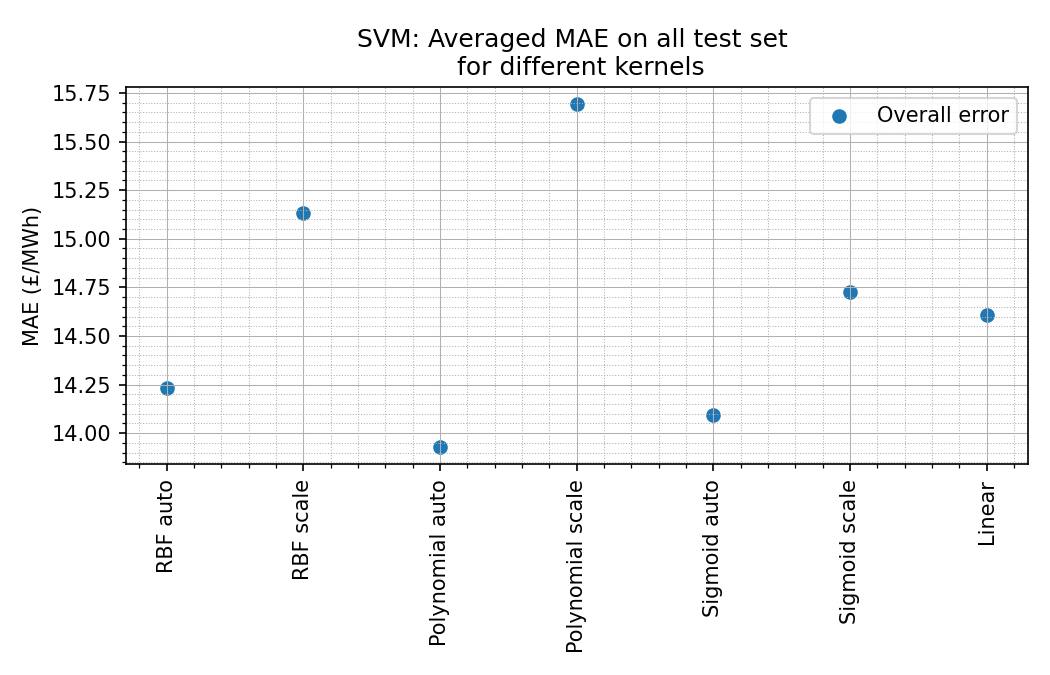

<IPython.core.display.Javascript object>


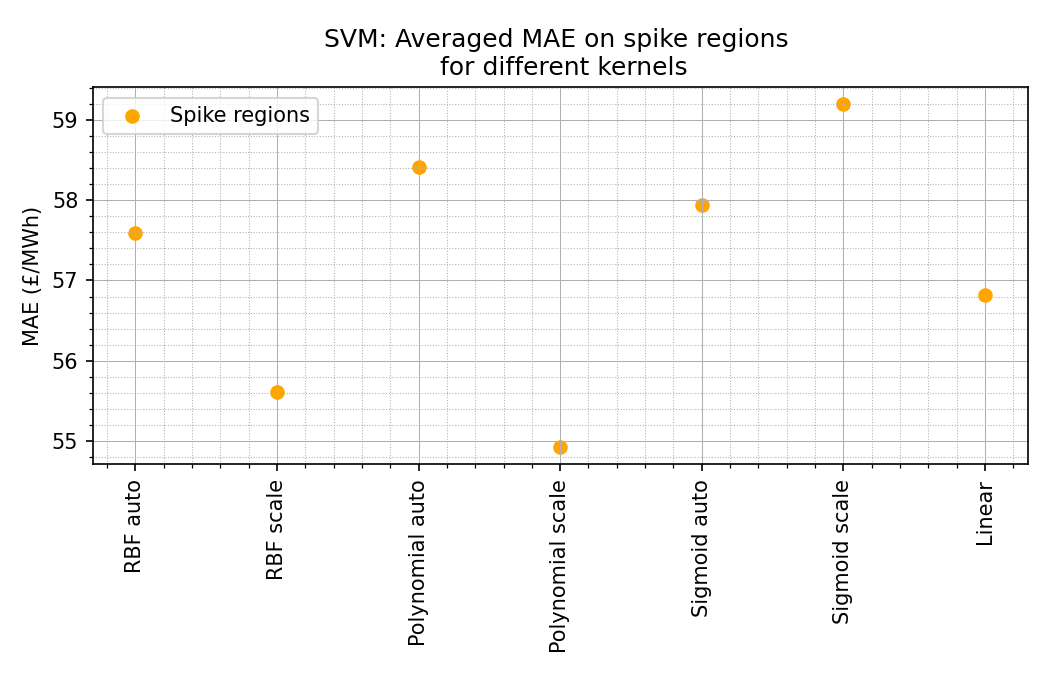

<IPython.core.display.Javascript object>


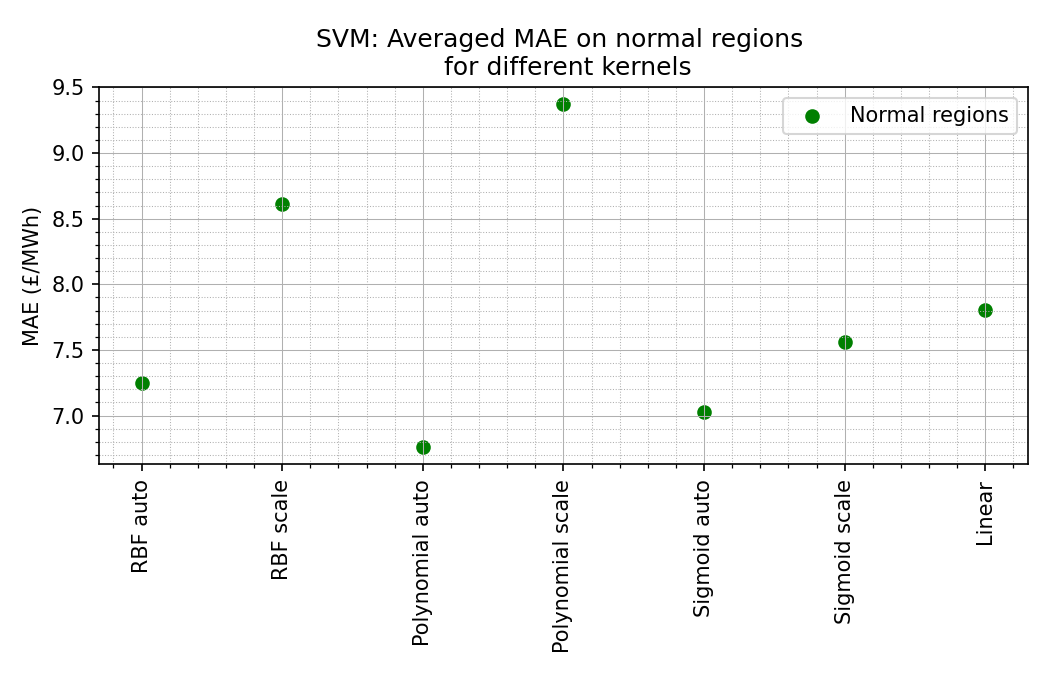

In [37]:
%matplotlib notebook

import matplotlib.pyplot as plt

plt.figure(figsize=(7,4.5))
plt.minorticks_on()
plt.grid(which='major', linestyle='-', linewidth='0.5')
plt.grid(which='minor', linestyle=':', linewidth='0.5')
plt.title('SVM: Averaged MAE on all test set \n for different kernels')
plt.scatter(x = list(range(len(mae_gen))), y = mae_gen, label = 'Overall error')
plt.legend()
plt.ylabel('MAE (£/MWh)')
plt.xticks(list(range(len(rmse_gen))), kernel_label, rotation = 90)
plt.tight_layout()
plt.savefig('MAE_best_kernel_all.png')

plt.figure(figsize=(7,4.5))
plt.minorticks_on()
plt.grid(which='major', linestyle='-', linewidth='0.5')
plt.grid(which='minor', linestyle=':', linewidth='0.5')
plt.title('SVM: Averaged MAE on spike regions \n for different kernels')
plt.scatter(x = list(range(len(mae_gen))), y = mae_spi, label = 'Spike regions', color = 'orange')
plt.legend()
plt.ylabel('MAE (£/MWh)')
plt.xticks(list(range(len(rmse_gen))), kernel_label, rotation = 90)
plt.tight_layout()
plt.savefig('MAE_best_kernel_spike.png')


plt.figure(figsize=(7,4.5))
plt.minorticks_on()
plt.grid(which='major', linestyle='-', linewidth='0.5')
plt.grid(which='minor', linestyle=':', linewidth='0.5')
plt.title('SVM: Averaged MAE on normal regions \n for different kernels')
plt.scatter(x = list(range(len(mae_gen))), y = mae_nor, label = 'Normal regions', color = 'green')
plt.legend()
plt.ylabel('MAE (£/MWh)')
plt.xticks(list(range(len(rmse_gen))), kernel_label, rotation = 90)
plt.tight_layout()
plt.savefig('MAE_best_kernel_normal.png')